In [1]:
# Базовые библиотеки
import numpy as np
import pandas as pd
import seaborn as sns

# Все для машинного обучения
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Игнорируем ошибки
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загружаем тренировочный, тестовый датасет и пример результатов
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
result_example = pd.read_csv('data/gender_submission.csv')

In [3]:
# Посмотрим на наш тренировочный датасет
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
# Аналогично взглянем на тестовый датасет
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [5]:
# Оставляем тут метку, чтобы в будущем было удобно делать датафрейм результатов
passenger_id = test['PassengerId']

# Количество объектов в нашем датасете
data_len = len(train)

# Сразу делаем Y для обучения
y_train = train['Survived']

# Соединяем тренировочный и тестовый датасет
X = pd.concat([train, test])

# Понадобится для обучения моделей
kfold = StratifiedKFold(n_splits=8)

In [6]:
# Отобразим пример результатов, чтобы правильно написать функцию для сохранения файла
result_example.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [7]:
# Функция для быстрого сохранения результата
def save_result(predict, file_name):
    predict_df = pd.DataFrame({'PassengerId': passenger_id, 'Survived': predict})
    predict_df.to_csv(file_name, index=False)

# 1. Для начала посмотрим на графики и проанализируем их

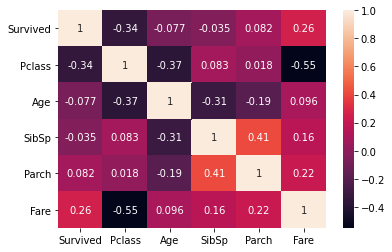

In [8]:
# Построим график корреляции
sns.heatmap(train[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True);

Видно, что одна переменная имеет сильную корреляцию по сравнению с другими.<br>
Чтож, посмотрим на другие графики

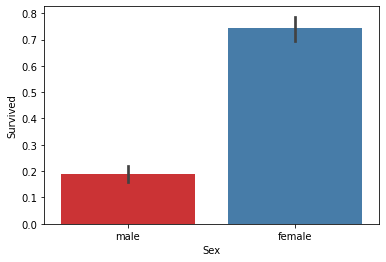

In [9]:
# Здесь мы смотрим соотношение выживших по критерию пола
sns.barplot(x='Sex', y='Survived', data=train, palette='Set1');

Также сильно бросается в глаза то, что женщин выжило в разы больше, чем мужчин

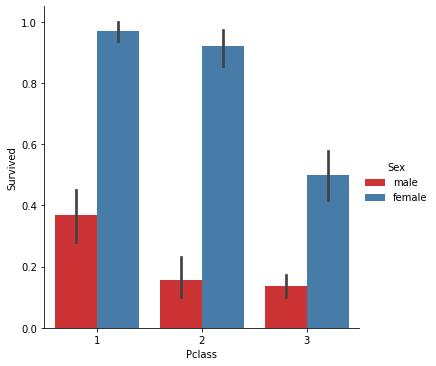

In [10]:
# На этом графике более наглядно можно увидеть соотношение выживших мужчин и женщин в каждом классе
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='bar', palette='Set1');

Если посмотреть на график соотношения выживших мужчин и женщин в разных классах, то можно заметить, что тенденция выживаемости сохраняется, как и на предыдущих графиках

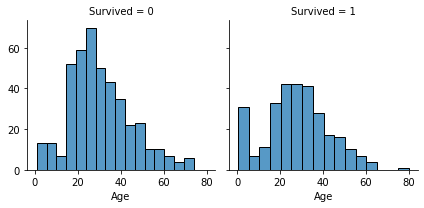

In [11]:
# График зависимости возраста от выживания пассажира
sns.FacetGrid(train, col='Survived').map(sns.histplot, 'Age');

На данном графике очень хорошо видно, что у молодых больше шансов выжить, чем у пожилых. Это вполне логичное явление

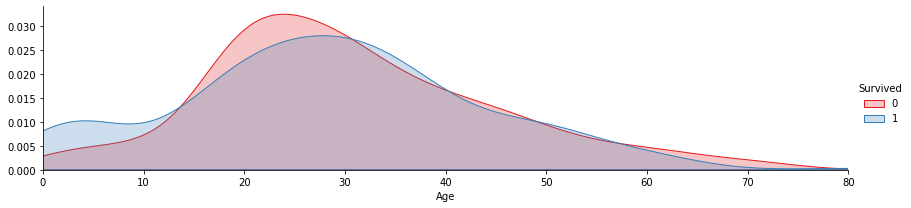

In [12]:
graph_age = sns.FacetGrid(train, hue='Survived', aspect=4, palette='Set1')
graph_age.map(sns.kdeplot, 'Age', shade=True)
graph_age.set(xlim=(0, train['Age'].max()))
graph_age.add_legend();

Еще один график соотношения возраста и выживаемости пассажира для лучшей наглядности

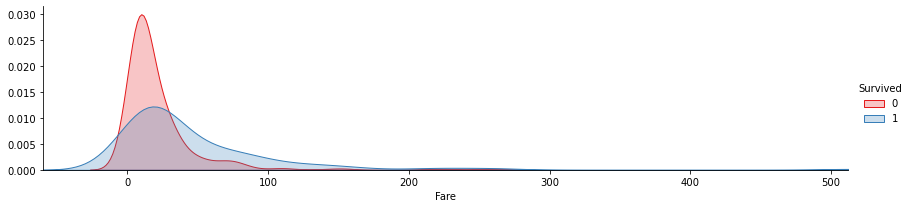

In [13]:
graph_age = sns.FacetGrid(train, hue='Survived', aspect=4, palette='Set1')
graph_age.map(sns.kdeplot, 'Fare', shade=True)
graph_age.set(xlim=(-60, train['Fare'].max()))
graph_age.add_legend();

График соотношения цены на билет и выживаемости пассажира. На нем можно заметить, что больше всего людей погибло с бюджетными билетами, что тоже имеет логику, так как маленькая цена говорит о том, что пассажир сидел не в приоритетном классе. Также это объясняется тем, что людей в бюджетном классе было больше всего.

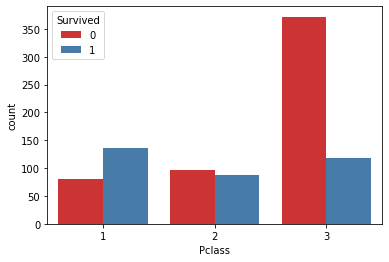

In [14]:
sns.countplot(data=train, x='Pclass', hue='Survived', palette='Set1');

Дополнительный график, который отображает количество выживших и погибших пассажиров между классами их билета

# 2. Подготовим наш датасет для обучения
## 2.1 Поработаем над пропущенными значениями

In [15]:
# Заполним пустые значения возраста на медианные значения всех возрастов
X['Age'].fillna(X['Age'].median(), inplace=True)

In [16]:
# Заполним пустое значение Fare его медианным значением по всем наблюдениям
X['Fare'].fillna(X['Fare'].median(), inplace=True)

## 2.2 Полезный Feature Engineering
Данный код я позаимствовал из другого проекта.<br>
Он группирует семьи и людей с одинаковыми билетами и исследует их информацию.<br>
Подробнее вы можете прочитать в <a href='https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever' target='_blank'>оригинале</a>

In [17]:
X['Family_Size'] = X['Parch'] + X['SibSp']
X['Last_Name'] = X['Name'].apply(lambda x: str.split(x, ",")[0])
X['Family_Survival'] = 0.5

In [18]:
for grp, grp_df in X[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 0

In [19]:
for _, grp_df in X.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 0

## 2.3 Финальная предобработка

In [20]:
# Создадим новую колонку, в которую распределим колонку Fare на 5 диапазонов значений
X['FareBin'] = pd.qcut(X['Fare'], 5)

# Исходя из нашей предыдущей колонки определим к какому номеру группы приравняется FareBin
X['FareBin_Code'] = LabelEncoder().fit_transform(X['FareBin'])

# Удаляем колонку Fare
X.drop('Fare', axis=1, inplace=True)

In [21]:
# Создадим новую колонку, в которую распределим колонку Age на 4 диапазона значений
X['AgeBin'] = pd.qcut(X['Age'], 4)

# Исходя из нашей предыдущей колонки определим к какому номеру группы приравняется AgeBin
X['AgeBin_Code'] = LabelEncoder().fit_transform(X['AgeBin'])

# Удаляем колонку Age
X.drop('Age', axis=1, inplace=True)

In [22]:
# Переделаем пол в номинативный формат. Мужчина = 0, Женщина = 1
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})

In [23]:
# Уберем лишние колонки для Х
X.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked', 'Last_Name', 'FareBin', 'AgeBin', 'Survived'], axis = 1, inplace = True)

In [24]:
# Резделим обратно наши датасеты на тренировочный и тестовый
X_train = X[:data_len]
X_test = X[data_len:]

In [25]:
# Создадим скаляр и преобразуем наши данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Приступим к обучению модели
## 3.1 Метод Random Forest

In [26]:
# Подключим наш классификатор
clf_rf = RandomForestClassifier()

In [27]:
# Пробежимся по данным параметрам для нахождения лучших
rf_param = {'min_samples_leaf': [5, 7, 9], 'bootstrap': [False, True], 'n_estimators' :[200, 400], 
                 'criterion': ['gini', 'entropy']}

In [28]:
# Эти лучшие параметры уже переписаны, чтобы потом сократить время обучения
rf_param_best = {'bootstrap': [False], 'criterion': ['gini'], 'max_depth': [None], 'max_features': [3], 
                 'min_samples_leaf': [5], 'min_samples_split': [4], 'n_estimators': [200]}

In [29]:
# Прогоним наш классификатор с заданными параметрами и с настроенной кросс-валидацией
gs_rf = GridSearchCV(clf_rf, rf_param_best, cv=kfold, scoring='roc_auc', n_jobs=-1)

In [30]:
# Обучаем нашу модель
gs_rf.fit(X_train, y_train);

In [31]:
# Сохраняем лучший классификатор в переменную и выводим лучшие параметры и оценку метрики
rf_best = gs_rf.best_estimator_
# print('Лучшие параметры для обучения:', gs_rf.best_params_)
print('Лучшая оценка метрики:', gs_rf.best_score_)

Лучшая оценка метрики: 0.8836035825688551


## 3.2 Метод XGBoost

In [32]:
# Создаем классификатор
xgb_clf = XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)

In [33]:
# Параметры для поиска наилучших
xgb_param = {'learning_rate':[0.05, 0.1], 'reg_lambda':[0.3, 0.5], 'gamma': [0.8, 1], 
                  'subsample': [0.8, 1], 'max_depth': [2, 3], 'n_estimators': [200, 300]}

In [34]:
# Лучшие параметры
xgb_param_best = {'gamma': [1], 'learning_rate': [0.05], 'max_depth': [2], 
                       'n_estimators': [300], 'reg_lambda': [0.3], 'subsample': [0.8]}

In [35]:
# Прогоняем наш классификатор по аналогии с предыдущим методом
greed_xgb = GridSearchCV(xgb_clf, xgb_param_best, cv=kfold, scoring='roc_auc', n_jobs=-1)

In [36]:
# Обучаем нашу модель
greed_xgb.fit(X_train, y_train);

In [37]:
# Сохраняем лучший классификатор в переменную и выводим лучшие параметры и оценку метрики
xgb_best = greed_xgb.best_estimator_
# print('Лучшие параметры для обучения:', gs_xgb.best_params_)
print('Лучшая оценка метрики:', greed_xgb.best_score_)

Лучшая оценка метрики: 0.887467897927624


## 3.3 Логистическая регрессия

In [38]:
# Создаем классификатор логистической регрессии
log_clf = LogisticRegression()

In [39]:
# Прогоним модель через данные параметры для нахождения лучших
log_param = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'dual': [True, False], 'C': [0.2, 0.4, 0.6, 0.8, 1.0],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [40]:
# Лучшие параметры
log_param_best = {'C': [0.4], 'dual': [True], 'penalty': ['l2'], 'solver': ['liblinear']}

In [41]:
# Прогоняем классификатор
greed_log = GridSearchCV(log_clf, log_param, cv=kfold, scoring='roc_auc', n_jobs=-1)

In [42]:
# Обучаем нашу модель
greed_log.fit(X_train, y_train);

In [43]:
# Сохраняем лучший классификатор в переменную и выводим лучшие параметры и оценку метрики
log_best = greed_log.best_estimator_
# print('Лучшие параметры для обучения:', greed_log.best_params_)
print('Лучшая оценка метрики:', greed_log.best_score_)

Лучшая оценка метрики: 0.8777296792495225


## 3.4 Метод ближайших соседей

In [44]:
# Создаем классификатор
knn_clf = KNeighborsClassifier()

In [45]:
# Параметры для подбора
knn_param = {'algorithm': ['auto'], 'weights': ['uniform', 'distance'], 
             'leaf_size': [20, 25, 30], 'n_neighbors': [12, 14, 16]}

In [46]:
# Лучшие параметры
knn_param_best = {'algorithm': ['auto'], 'leaf_size': [25], 
                  'n_neighbors': [16], 'weights': ['uniform']}

In [47]:
# Прогоняем классификатор
greed_knn = GridSearchCV(knn_clf, knn_param_best, cv=kfold, scoring='roc_auc', n_jobs=-1)

In [48]:
# Обучаем нашу модель
greed_knn.fit(X_train, y_train);

In [49]:
# Сохраняем лучший классификатор в переменную и выводим лучшие параметры и оценку метрики
knn_best = greed_knn.best_estimator_
# print('Лучшие параметры для обучения:', greed_knn.best_params_)
print('Лучшая оценка метрики:', greed_knn.best_score_)

Лучшая оценка метрики: 0.8813168003972738


## 3.5 Градиентный бустинг

In [50]:
# Создаем классификатор
grad_clf = GradientBoostingClassifier()

In [51]:
# Параметры для подбора
grag_param = {'loss' : ['deviance'], 'n_estimators' : [1000], 'learning_rate': [0.02, 0.05], 
                 'min_samples_split': [15, 20, 25], 'max_depth': [4, 6], 
                 'min_samples_leaf': [50, 60], 'max_features': ["sqrt"]}

In [52]:
# Лучшие параметры
grad_param_best = {'loss' : ["deviance"], 'n_estimators' : [1000], 'learning_rate': [0.02], 
                      'min_samples_split': [25], 'max_depth': [4], 
                      'min_samples_leaf': [60], 'max_features': ["sqrt"]}

In [53]:
# Прогоняем классификатор
greed_grad = GridSearchCV(grad_clf, grad_param_best, cv=kfold, scoring="roc_auc", n_jobs=-1)

In [54]:
# Обучаем нашу модель
greed_grad.fit(X_train, y_train);

In [55]:
# Сохраняем лучший классификатор в переменную и выводим лучшие параметры и оценку метрики
gb_best = greed_grad.best_estimator_
# print('GradienBoost GridSearch best params:', gs_gb.best_params_)
print('Лучшая оценка метрики:', greed_grad.best_score_)

Лучшая оценка метрики: 0.8838532653540014


# 4. Подводим итоги и сохраняем результат

Соберем вместе все наши метрики от разных методов обучения, чтобы найти наилучшую

In [59]:
# Собираем датасет из наших метрик
pd.DataFrame({'Random Forest': gs_rf.best_score_,'XGBoost': greed_xgb.best_score_, 
              'Regression': greed_log.best_score_, 'Neighbors': greed_knn.best_score_, 
              'Gradient': greed_grad.best_score_}, index=[1])

,Random Forest,XGBoost,Regression,Neighbors,Gradient
1,0.883604,0.887468,0.87773,0.881317,0.883853


In [60]:
# Создаем переменную, в которую запишем лучший метод для определения выживаемости пассажиров
best_method = xgb_best.predict(X_test)

In [61]:
# Вызываем нашу функцию и сохраняем файл с результатами
save_result(best_method, 'result.csv')